In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import xgboost as xgb

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from IPython.display import display


In [2]:
# !pip install xgboost


# Exploring "games" csv

In [3]:
#load data. GAME_ID, HOME_TEAM_ID, VISITOR_TEAM_ID, TEAM_ID_AWAY
games = pd.read_csv('Data/games.csv')
print(games.head(3))

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2020-12-19  12000047            Final    1610612753       1610612766   
1    2020-12-19  12000048            Final    1610612764       1610612765   
2    2020-12-19  12000049            Final    1610612763       1610612737   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2020    1610612753     120.0        0.433        0.792  ...      23.0   
1    2020    1610612764      99.0        0.427        0.625  ...      24.0   
2    2020    1610612763     116.0        0.400        0.744  ...      21.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  \
0      50.0    1610612766     117.0        0.444        0.864         0.439   
1      45.0    1610612765      96.0        0.402        0.647         0.326   
2      43.0    1610612737     117.0        0.422        0.837         0.297   

   AST_away  REB_away  HOME_TEAM_WINS  
0      21.0      52.0

In [4]:
games['pts_diff'] = games['PTS_home'] - games['PTS_away']
games['fg_pct_diff'] = games['FG_PCT_home'] - games['FG_PCT_away']
games['ft_pct_diff'] = games['FT_PCT_home'] - games['FT_PCT_away']
games['ast_diff'] = games['AST_home'] - games['AST_away']
games['reb_diff'] = games['REB_home'] - games['REB_away']

In [5]:
games_diff = games[['HOME_TEAM_ID','HOME_TEAM_WINS', 'pts_diff', 'fg_pct_diff', 'ft_pct_diff', 'ast_diff', 'reb_diff']]
games_diff.head(3)

,HOME_TEAM_ID,HOME_TEAM_WINS,pts_diff,fg_pct_diff,ft_pct_diff,ast_diff,reb_diff
0,1610612753,1,3.0,-0.011,-0.072,2.0,-2.0
1,1610612764,1,3.0,0.025,-0.022,6.0,-6.0
2,1610612763,0,-1.0,-0.022,-0.093,-3.0,-4.0


In [6]:
games.dtypes

GAME_DATE_EST        object
GAME_ID               int64
GAME_STATUS_TEXT     object
HOME_TEAM_ID          int64
VISITOR_TEAM_ID       int64
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
pts_diff            float64
fg_pct_diff         float64
ft_pct_diff         float64
ast_diff            float64
reb_diff            float64
dtype: object

In [7]:
# Home team win rate

n_matches = games_diff.shape[0]

n_features = games_diff.shape[1] - 1

n_homewins = len(games_diff[games_diff.HOME_TEAM_WINS == 1])

win_rate = (float(n_homewins) / (n_matches)) * 100

print("Total number of matches: {}".format(n_matches))
print("Number of features: {}".format(n_features))
print("Number of matches won by home team: {}".format(n_homewins))
print("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 23520
Number of features: 6
Number of matches won by home team: 13901
Win rate of home team: 59.10%


array([[<AxesSubplot:xlabel='HOME_TEAM_WINS', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='pts_diff', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='fg_pct_diff', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='ft_pct_diff', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='ast_diff', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='reb_diff', ylabel='HOME_TEAM_WINS'>],
       [<AxesSubplot:xlabel='HOME_TEAM_WINS', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='pts_diff', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='fg_pct_diff', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='ft_pct_diff', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='ast_diff', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='reb_diff', ylabel='pts_diff'>],
       [<AxesSubplot:xlabel='HOME_TEAM_WINS', ylabel='fg_pct_diff'>,
        <AxesSubplot:xlabel='pts_diff', ylabel='fg_pct_diff'>,
        <AxesSubplot:xlabel='fg_pct_diff', ylabel='fg_pct_diff'>,
        <AxesSubplot

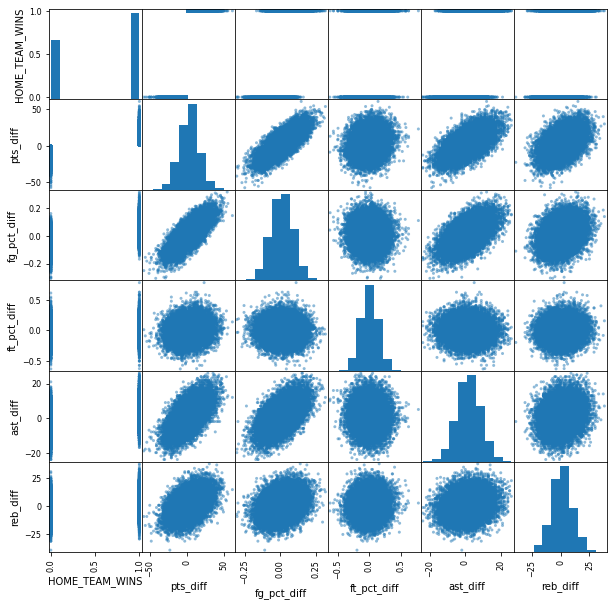

In [8]:
from pandas.plotting import scatter_matrix

scatter_matrix(games_diff[['HOME_TEAM_WINS','pts_diff','fg_pct_diff','ft_pct_diff','ast_diff','reb_diff']], figsize=(10,10))

In [9]:
# sml = Speedml('games.csv',
#               target='Survived', uid='PassengerId')
# sml.shape()

In [10]:
games['pts_diff'] = games['PTS_home'] / games['PTS_away']
games['fg_pct_diff'] = games['FG_PCT_home'] / games['FG_PCT_away']
games['ft_pct_diff'] = games['FT_PCT_home'] / games['FT_PCT_away']
games['ast_diff'] = games['AST_home'] / games['AST_away']
games['reb_diff'] = games['REB_home'] / games['REB_away']

In [11]:
games_diff = games[['HOME_TEAM_WINS', 'pts_diff', 'fg_pct_diff', 'ft_pct_diff', 'ast_diff', 'reb_diff']]
games_diff.head(3)

,HOME_TEAM_WINS,pts_diff,fg_pct_diff,ft_pct_diff,ast_diff,reb_diff
0,1,1.025641,0.975225,0.916667,1.095238,0.961538
1,1,1.031250,1.062189,0.965997,1.333333,0.882353
2,0,0.991453,0.947867,0.888889,0.875000,0.914894


array([[<AxesSubplot:xlabel='HOME_TEAM_WINS', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='pts_diff', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='fg_pct_diff', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='ft_pct_diff', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='ast_diff', ylabel='HOME_TEAM_WINS'>,
        <AxesSubplot:xlabel='reb_diff', ylabel='HOME_TEAM_WINS'>],
       [<AxesSubplot:xlabel='HOME_TEAM_WINS', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='pts_diff', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='fg_pct_diff', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='ft_pct_diff', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='ast_diff', ylabel='pts_diff'>,
        <AxesSubplot:xlabel='reb_diff', ylabel='pts_diff'>],
       [<AxesSubplot:xlabel='HOME_TEAM_WINS', ylabel='fg_pct_diff'>,
        <AxesSubplot:xlabel='pts_diff', ylabel='fg_pct_diff'>,
        <AxesSubplot:xlabel='fg_pct_diff', ylabel='fg_pct_diff'>,
        <AxesSubplot

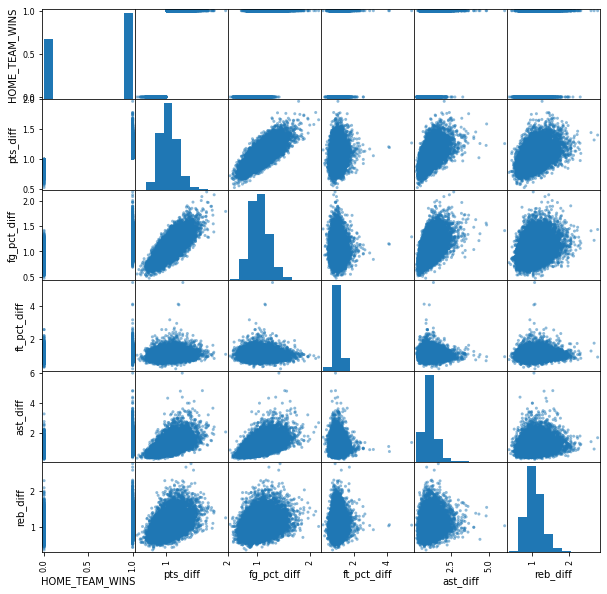

In [12]:
from pandas.plotting import scatter_matrix

scatter_matrix(games_diff[['HOME_TEAM_WINS','pts_diff','fg_pct_diff','ft_pct_diff','ast_diff','reb_diff']], figsize=(10,10))

# Games Details

In [13]:
# games_details_df = pd.read_csv('Data/games_details.csv')
# print(games_details_df.head())

In [14]:
# players_df = pd.read_csv('Data/players.csv')
# print(players_df.head())

In [15]:
ranking_df = pd.read_csv('Data/ranking.csv')
print(ranking_df.head())

      TEAM_ID  LEAGUE_ID  SEASON_ID STANDINGSDATE CONFERENCE         TEAM  G  \
0  1610612747          0      12020    2020-12-21       West  L.A. Lakers  4   
1  1610612762          0      12020    2020-12-21       West         Utah  3   
2  1610612740          0      12020    2020-12-21       West  New Orleans  2   
3  1610612745          0      12020    2020-12-21       West      Houston  4   
4  1610612763          0      12020    2020-12-21       West      Memphis  4   

   W  L  W_PCT HOME_RECORD ROAD_RECORD  RETURNTOPLAY  
0  4  0   1.00         2-0         2-0           NaN  
1  3  0   1.00         2-0         1-0           NaN  
2  2  0   1.00         1-0         1-0           NaN  
3  3  1   0.75         2-0         1-1           NaN  
4  3  1   0.75         1-1         2-0           NaN  


In [16]:
games = pd.read_csv('Data/games.csv')
print(games.head())

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2020-12-19  12000047            Final    1610612753       1610612766   
1    2020-12-19  12000048            Final    1610612764       1610612765   
2    2020-12-19  12000049            Final    1610612763       1610612737   
3    2020-12-18  12000039            Final    1610612754       1610612755   
4    2020-12-18  12000040            Final    1610612761       1610612748   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2020    1610612753     120.0        0.433        0.792  ...      23.0   
1    2020    1610612764      99.0        0.427        0.625  ...      24.0   
2    2020    1610612763     116.0        0.400        0.744  ...      21.0   
3    2020    1610612754     107.0        0.371        0.692  ...      19.0   
4    2020    1610612761     105.0        0.380        0.737  ...      27.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_P

In [17]:
print(ranking_df["SEASON_ID"].unique())

[12020 22019 12019 22013 12013 22012 12012 22011 12011 22010 12010 22009
 12009 22008 12008 22007 12007 22006 12006 22005 12005 22004 12004 22003
 12003 22002 22018 12018 22017 12017 22016 12016 22015 12015 22014 12014]


In [18]:
print(games["SEASON"].unique())

[2020 2019 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003 2018
 2017 2016 2015 2014]


In [19]:
ranking_df.dtypes

TEAM_ID            int64
LEAGUE_ID          int64
SEASON_ID          int64
STANDINGSDATE     object
CONFERENCE        object
TEAM              object
G                  int64
W                  int64
L                  int64
W_PCT            float64
HOME_RECORD       object
ROAD_RECORD       object
RETURNTOPLAY     float64
dtype: object

In [20]:
games.dtypes

GAME_DATE_EST        object
GAME_ID               int64
GAME_STATUS_TEXT     object
HOME_TEAM_ID          int64
VISITOR_TEAM_ID       int64
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
dtype: object

In [21]:
ranking_df['SEASON'] = ranking_df['SEASON_ID']
ranking_df

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,SEASON
0,1610612747,0,12020,2020-12-21,West,L.A. Lakers,4,4,0,1.000,2-0,2-0,NaN,12020
1,1610612762,0,12020,2020-12-21,West,Utah,3,3,0,1.000,2-0,1-0,NaN,12020
2,1610612740,0,12020,2020-12-21,West,New Orleans,2,2,0,1.000,1-0,1-0,NaN,12020
3,1610612745,0,12020,2020-12-21,West,Houston,4,3,1,0.750,2-0,1-1,NaN,12020
4,1610612763,0,12020,2020-12-21,West,Memphis,4,3,1,0.750,1-1,2-0,NaN,12020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188378,1610612765,0,22013,2014-09-01,East,Detroit,82,29,53,0.354,17-24,12-29,NaN,22013
188379,1610612738,0,22013,2014-09-01,East,Boston,82,25,57,0.305,16-25,9-32,NaN,22013
188380,1610612753,0,22013,2014-09-01,East,Orlando,82,23,59,0.280,19-22,4-37,NaN,22013
188381,1610612755,0,22013,2014-09-01,East,Philadelphia,82,19,63,0.232,10-31,9-32,NaN,22013


In [22]:
ranking_df['SEASON'] = ranking_df['SEASON'].astype(str)
ranking_df['SEASON'] = ranking_df['SEASON'].str[1:]

In [23]:
ranking_df.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,SEASON
0,1610612747,0,12020,2020-12-21,West,L.A. Lakers,4,4,0,1.00,2-0,2-0,NaN,2020
1,1610612762,0,12020,2020-12-21,West,Utah,3,3,0,1.00,2-0,1-0,NaN,2020
2,1610612740,0,12020,2020-12-21,West,New Orleans,2,2,0,1.00,1-0,1-0,NaN,2020
3,1610612745,0,12020,2020-12-21,West,Houston,4,3,1,0.75,2-0,1-1,NaN,2020
4,1610612763,0,12020,2020-12-21,West,Memphis,4,3,1,0.75,1-1,2-0,NaN,2020


In [24]:
games['SEASON'] = games['SEASON'].astype(str)

In [25]:
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2020-12-19,12000047,Final,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,...,23.0,50.0,1610612766,117.0,0.444,0.864,0.439,21.0,52.0,1
1,2020-12-19,12000048,Final,1610612764,1610612765,2020,1610612764,99.0,0.427,0.625,...,24.0,45.0,1610612765,96.0,0.402,0.647,0.326,18.0,51.0,1
2,2020-12-19,12000049,Final,1610612763,1610612737,2020,1610612763,116.0,0.400,0.744,...,21.0,43.0,1610612737,117.0,0.422,0.837,0.297,24.0,47.0,0
3,2020-12-18,12000039,Final,1610612754,1610612755,2020,1610612754,107.0,0.371,0.692,...,19.0,45.0,1610612755,113.0,0.533,0.629,0.355,23.0,48.0,0
4,2020-12-18,12000040,Final,1610612761,1610612748,2020,1610612761,105.0,0.380,0.737,...,27.0,37.0,1610612748,117.0,0.534,0.741,0.514,30.0,51.0,0


In [26]:
ranking_df['TEAM_ID'].value_counts()

1610612751    6292
1610612765    6292
1610612738    6292
1610612739    6292
1610612740    6292
1610612741    6292
1610612742    6292
1610612743    6292
1610612744    6292
1610612745    6292
1610612746    6292
1610612747    6292
1610612748    6292
1610612749    6292
1610612750    6292
1610612737    6292
1610612752    6292
1610612753    6292
1610612754    6292
1610612755    6292
1610612756    6292
1610612757    6292
1610612758    6292
1610612759    6292
1610612760    6292
1610612761    6292
1610612762    6292
1610612763    6292
1610612764    6292
1610612766    5915
Name: TEAM_ID, dtype: int64

In [27]:
ranking_df['SEASON'].unique

<bound method Series.unique of 0         2020
1         2020
2         2020
3         2020
4         2020
          ... 
188378    2013
188379    2013
188380    2013
188381    2013
188382    2013
Name: SEASON, Length: 188383, dtype: object>

In [28]:
len(games)

23520

In [29]:
len(ranking_df)

188383

In [30]:
# teams_df = pd.read_csv('Data/teams.csv')
# print(teams_df.head())

In [46]:
gameslist = list(games.columns)
rankinglist=["W_PCT"]
gameslist+rankinglist

['GAME_DATE_EST',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON_x',
 'PTS_home',
 'FG_PCT_home',
 'FT_PCT_home',
 'FG3_PCT_home',
 'AST_home',
 'REB_home',
 'PTS_away',
 'FG_PCT_away',
 'FT_PCT_away',
 'FG3_PCT_away',
 'AST_away',
 'REB_away',
 'VISITOR_W_PCT',
 'TEAM_ID',
 'LEAGUE_ID',
 'SEASON_ID',
 'STANDINGSDATE',
 'CONFERENCE',
 'TEAM',
 'G',
 'W',
 'L',
 'HOME_W_PCT',
 'HOME_RECORD',
 'ROAD_RECORD',
 'RETURNTOPLAY',
 'SEASON_y',
 'W_PCT']

In [56]:
# LEFT JOIN GAMES WITH RANKING_DF ON DATE AND GAME_ID
games = pd.merge(games, ranking_df,  how='left', left_on=['GAME_DATE_EST','HOME_TEAM_ID'], right_on = ['STANDINGSDATE','TEAM_ID'])

In [57]:
games = games.rename(columns={"W_PCT":"HOME_W_PCT"})
games.head(3)

,GAME_DATE_EST,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON_x,SEASON_x,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,CONFERENCE_y,TEAM_y,G_y,W_y,L_y,HOME_W_PCT,HOME_RECORD_y,ROAD_RECORD_y,RETURNTOPLAY_y,SEASON
0,2020-12-19,1610612753,1610612766,2020,2020,120.0,0.433,0.792,0.425,23.0,...,East,Orlando,4,2,2,0.500,1-1,1-1,NaN,2020
1,2020-12-19,1610612764,1610612765,2020,2020,99.0,0.427,0.625,0.295,24.0,...,East,Washington,3,1,2,0.333,1-1,0-1,NaN,2020
2,2020-12-19,1610612763,1610612737,2020,2020,116.0,0.400,0.744,0.396,21.0,...,West,Memphis,4,3,1,0.750,1-1,2-0,NaN,2020


In [58]:
games = pd.merge(games, ranking_df, how='left', left_on=["VISITOR_TEAM_ID", "GAME_DATE_EST"], right_on=["TEAM_ID", "STANDINGSDATE"])[gameslist+rankinglist]

In [59]:
games = games.rename(columns={"W_PCT": "VISITOR_W_PCT"})
games.head(3)

,GAME_DATE_EST,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON_x,SEASON_x,SEASON_x,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,...,HOME_W_PCT,HOME_W_PCT,HOME_W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,SEASON_y,SEASON_y,SEASON_y,VISITOR_W_PCT
0,2020-12-19,1610612753,1610612766,2020,2020,2020,120.0,0.433,0.792,0.425,...,0.500,0.500,0.500,0-2,1-1,NaN,2020,2020,2020,0.25
1,2020-12-19,1610612764,1610612765,2020,2020,2020,99.0,0.427,0.625,0.295,...,0.333,0.333,0.333,1-1,1-1,NaN,2020,2020,2020,0.50
2,2020-12-19,1610612763,1610612737,2020,2020,2020,116.0,0.400,0.744,0.396,...,0.750,0.750,0.750,1-1,1-1,NaN,2020,2020,2020,0.50


In [62]:
gamesdf = games.drop(columns=['GAME_ID', 'GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away', 'HOME_TEAM_WINS'])
gamesdf

KeyError: "['GAME_ID' 'GAME_STATUS_TEXT' 'TEAM_ID_home' 'TEAM_ID_away'\n 'HOME_TEAM_WINS'] not found in axis"

In [52]:
#BREAK GAMES DF INTO HOME AND AWAY. TAKE WHATEVER COLUMNS WE WANT FROM RANKING_DF. MAKE A W_PCT HOME AND AWAY COLUMNS.
